In [2]:
import prepare_data as prep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
%matplotlib inline

# Check Time Alignment

We should check that the GPS track and the ML detections start at the same time for each track. This tells us we've aligned the correct waves and also that the camera timing issues are likely modest (although doesn't completely rule out issue)

In [3]:
print(prep.detect[0]['timestamp'][0])
print(prep.gps[0]['timestamp'][0])

print(prep.detect[1]['timestamp'][0])
print(prep.gps[1]['timestamp'][0])

1560817389300.0
1560817383000
1560816480599.0
1560816473999


In [4]:
def make_time_index(df):
    df['date'] = pd.to_datetime(df['timestamp'].astype(int), unit='ms')
    df['date'] = df['date'].dt.round("1S")
    df = df.set_index('date')
    return df

In [5]:
def get_merged_df(gps, detect):
    gps = make_time_index(gps)
    detect = make_time_index(detect)
    detect = detect.resample('1s').mean().astype(int)
    detect['latitude'] = gps['latitude']
    detect['longitude'] = gps['longitude']
    return detect.dropna()

In [6]:
merged1 = get_merged_df(prep.gps[1], prep.detect[1])
merged2 = get_merged_df(prep.gps[0], prep.detect[0])

In [7]:
df = pd.concat([merged2, merged1])

In [8]:
source_points = np.stack((df['x'], df['y']), axis=-1)
dest_points = np.stack((df['latitude'], df['longitude']), axis=-1)

# Add the beta oil platform, pier pylons and lifeguard tower
33.5892572,-118.1204342


In [9]:
# Reset the sessions points and ignore them.
source_points = np.empty([1,2])
dest_points = np.empty([1,2])
source_points = np.vstack([source_points, [[1109, 449],
                                           [492, 695],
                                           [370, 775],
                                           [180, 960],
                                           [1000, 1020]]])
dest_points = np.vstack([dest_points, [[33.5892572, -118.1204342],
                                       [33.653234, -118.006400],
                                       [33.654103, -118.005418],
                                       [33.655173, -118.004233],
                                       [33.656026, -118.003920]]])
source_points = source_points[1:]
dest_points = dest_points[1:]

In [11]:
hom = cv2.findHomography(dest_points, source_points)[0]

In [12]:
print(hom)

[[-1.42616939e+01  2.04327398e+01  2.89112723e+03]
 [ 5.31990492e+00  1.87305571e+00  4.19728202e+01]
 [ 3.06516356e-03  9.34858215e-03  1.00000000e+00]]


In [13]:
def get_xy(lat, lon, hom):
    inp = [lat, lon, 1]
    res = np.matmul(hom, inp)
    x = res[0] / res[2]
    y = res[1] / res[2]
    return int(x), int(y)

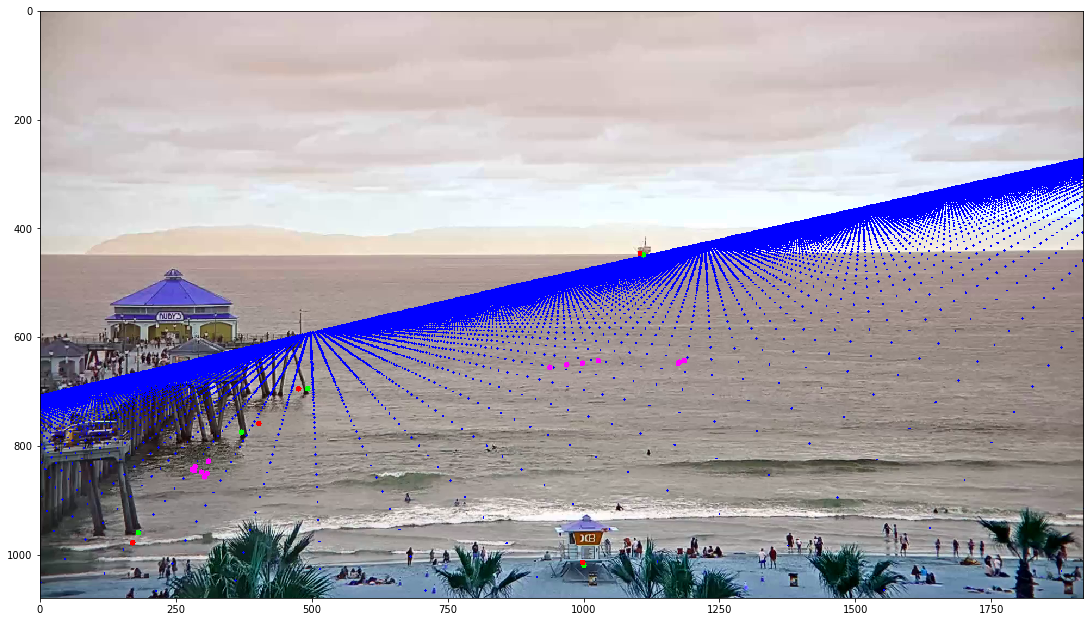

In [14]:
def visualize(source_points, dest_points, hom):

    vidcap = cv2.VideoCapture('./data/hb_n.mp4')
    success,image = vidcap.read()
    
    # Show the grid in blue
    for lat in np.arange(33.63, 33.80, 0.0001):
        for lon in np.arange(-118.003, -118.04, -0.0001):
            sp = get_xy(lat, lon, hom)
            cv2.circle(image, (sp[0], sp[1]), 2, (0, 0, 255), -1)

    # Show the tower, pylon and hut source points in green
    for point in source_points:
        cv2.circle(image, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1)

    # Show the estimated pylon, hut and pier points in red
    for point in dest_points:
        sp = get_xy(point[0], point[1], hom)
        cv2.circle(image, (sp[0], sp[1]), 5, (255, 0, 0), -1)
    
    # Show the surf sessions points in pink
    for point in np.stack((df['latitude'], df['longitude']), axis=-1):
        sp = get_xy(point[0], point[1], hom)
        cv2.circle(image, (sp[0], sp[1]), 5, (255, 0, 255), -1)
        
    plt.figure(figsize=(19.2, 10.8))
    plt.imshow(image)
    
visualize(source_points, dest_points, hom)

# Conclusion

Neither surfer detection data from two sessions, nor manually labelled points create a realistic homography. In both cases it fits the data reasonably but doesn't generalise (see example above). Combining both sets gives a worse outcome. 

It's likely that the noise in both datasets is a problem, along with the amount of data versus the degrees of freedom of the homography. We either need better data or more data.

In [16]:
hom[2][0] = hom[1][0] / 420
hom[2][1] = hom[1][1] / 420

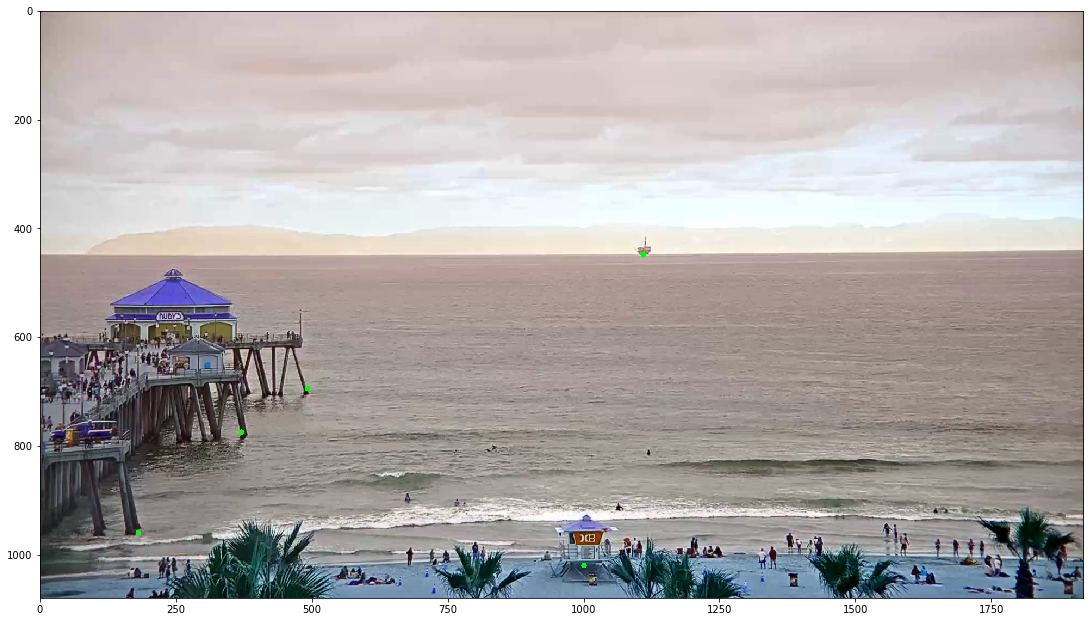

In [17]:
visualize(source_points, dest_points, hom)